In [3]:
# !pip install -q -U einops
%matplotlib inline


In [1]:
import json
import os
import random
import pickle
import time
import numpy
import numpy as np
from tqdm.auto import tqdm

from inspect import isfunction
from functools import partial
import math
from einops import rearrange

import torch
import torch.nn.functional as F
from torch import nn
from torch import einsum
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.utils import make_grid, save_image
from torchvision import transforms

import matplotlib
# matplotlib.use("tkagg")
import matplotlib.pyplot as plt
from pathlib import Path


def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


fix_experiment_seed()

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Helper Functions
def show_image(image, nrow=8):
    # Input: image
    # Displays the image using matplotlib
    grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [3]:
def save_logs(dictionary, log_dir):
    log_dir = os.path.join(log_dir)
    os.makedirs(log_dir, exist_ok=True)
    # Log arguments
    with open(os.path.join(log_dir, "log.json"), "w") as f:
        json.dump(dictionary, f, indent=2)

In [4]:
# Training Hyperparameters
train_batch_size = 64  # Batch Size
lr = 1e-4  # Learning Rate

# Hyperparameters taken from Ho et. al for noise scheduling
T = 1000  # Diffusion Timesteps
beta_start = 0.0001  # Starting variance
beta_end = 0.02  # Ending variance
# Define Dataset Statistics
image_size = 32
input_channels = 3
data_root = './data'

In [5]:
def get_dataloaders(data_root, batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
    transform = transforms.Compose((
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize))

    train = datasets.SVHN(data_root, split='train', download=True, transform=transform)
    test = datasets.SVHN(data_root, split='test', download=True, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    return train_dataloader, test_dataloader

In [6]:
# Visualize the Dataset
def visualize():
    train_dataloader, _ = get_dataloaders(data_root=data_root, batch_size=train_batch_size)
    imgs, labels = next(iter(train_dataloader))

    save_image((imgs + 1) * 0.5, './results/orig.png')
    show_image((imgs + 1) * 0.5)


# if __name__ == '__main__':
    # visualize()

In [7]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [8]:
class Unet(nn.Module):
    def __init__(self, dim, init_dim=None, out_dim=None, dim_mults=(1, 2, 4, 8), channels=3, with_time_emb=True,
                 resnet_block_groups=8, ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(SinusoidalPositionEmbeddings(dim),
                                          nn.Linear(dim, time_dim),
                                          nn.GELU(),
                                          nn.Linear(time_dim, time_dim), )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        noise_pred = self.final_conv(x)
        return noise_pred

In [9]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [10]:
def linear_beta_schedule(beta_start, beta_end, timesteps):
    return torch.linspace(beta_start, beta_end, timesteps)


betas = linear_beta_schedule(beta_start, beta_end, T)  # WRITE CODE HERE: Define the linear beta schedule
alphas = 1 - betas  # WRITE CODE HERE: Compute the alphas as 1 - betas
sqrt_recip_alphas = alphas.sqrt() ** -1  # WRITE CODE HERE: Returns 1/square_root(\alpha_t)
alphas_cumprod = alphas.cumprod(dim=0)  # WRITE CODE HERE: Compute product of alphas up to index t, \bar{\alpha}
sqrt_alphas_cumprod = alphas_cumprod.sqrt()  # WRITE CODE HERE: Returns sqaure_root(\bar{\alpha}_t)
sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod).sqrt()  # WRITE CODE HERE: Returns square_root(1 - \bar{\alpha}_t)
alphas_cumprod_prev = F.pad(alphas_cumprod, pad=[1, 0], value=1)[:T]
posterior_variance = (1 - alphas_cumprod_prev) / (1 - alphas_cumprod) * betas

In [11]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)  # WRITE CODE HERE: Obtain the cumulative product sqrt_alphas_cumprod up to a given point t in a batched manner for different t's
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)  # WRITE CODE HERE: Same as above, but for sqrt_one_minus_alphas_cumprod
    x_noisy = (sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise)
    return x_noisy

In [12]:
def visualize_diffusion():
    train_dataloader, _ = get_dataloaders(data_root=data_root, batch_size=train_batch_size)
    imgs, _ = next(iter(train_dataloader))
    sample = imgs[3].unsqueeze(0)
    noisy_images = [sample] + [q_sample(sample, torch.tensor([100 * t + 99])) for t in range(10)]
    noisy_images = (torch.cat(noisy_images, dim=0) + 1.) * 0.5
    show_image(noisy_images.clamp(0., 1.), nrow=11)


# if __name__ == '__main__':
#     visualize_diffusion()

In [13]:
def p_sample(model, x, t, t_index):
    with torch.no_grad():
        betas_t = extract(betas, t, x.shape)  # Similar to q_sample, extract betas for specific t's
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)  # Same as above, but for sqrt_one_minus_alphas_cumprod
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)  # Same as above, but for sqrt_recip_alphas
        p_mean = (sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * model(x, t)))
        if t_index == 0:
            sample = p_mean  # Set the sample as the mode
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)  # Same as betas_t, but for posterior_variance
            e_noise = torch.randn(size=x.shape, device=device)
            sample = p_mean + torch.pow(posterior_variance_t, 0.5) * e_noise

        return sample


def p_sample_loop(model, shape, timesteps):
    with torch.no_grad():
        b = shape[0]
        img = torch.randn(shape, device=device)
        imgs = []

        for i in tqdm(reversed(range(0, timesteps)), desc='Sampling', total=T, leave=False):
            img = p_sample(model, img, torch.full(size=(b,), fill_value=i, device=device), i)
            imgs.append(img.cpu())

        return torch.stack(imgs)


def sample(model, image_size, batch_size=16, channels=3):
    with torch.no_grad():
        return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), timesteps=T)

In [14]:
def p_losses(denoise_model, x_start, t):
    noise = torch.randn_like(x_start, device=device)
    x_noisy = q_sample(x_start, t, noise)  # Obtain the noisy image from the original images x_start, at times t, using the noise.
    predicted_noise = denoise_model(x_noisy, t)  # Obtain the prediction of the noise using the model.
    loss = nn.HuberLoss()(predicted_noise, noise)  # Compute the huber loss between true noise generated above, and the noise estimate obtained through the model.
    return loss

In [15]:
def t_sample(timesteps, batch_size):
    ts = torch.randint(0, timesteps, size=(batch_size,), device=device)
    return ts

In [16]:
if __name__ == '__main__':
    model = Unet(
        dim=image_size,
        channels=input_channels,
        dim_mults=(1, 2, 4, 8)
    )
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

In [17]:
train_dataloader, test_dataloader = get_dataloaders(data_root, batch_size=train_batch_size)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [18]:
# epochs = 1000
# start_epoch = 330

# with open(f"models/model_{start_epoch}" + ".pickle", 'rb') as f:
#     model = pickle.load(f)

# if __name__ == '__main__':
#     logger = dict()
#     logger['train_time'] = [0]
#     logger['train_losses'] = []
#     start_time = time.time()
#
#     train_dataloader, test_dataloader = get_dataloaders(data_root, batch_size=train_batch_size)
#     for epoch in range(start_epoch, epochs):
#         with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
#             for batch in tepoch:
#                 tepoch.set_description(f"Epoch: {epoch}")
#                 optimizer.zero_grad()
#                 imgs, _ = batch
#                 batch_size = imgs.shape[0]
#                 x = imgs.to(device)
#                 t = t_sample(T, batch_size)  # Randomly sample timesteps uniformly from [0, T-1]
#                 loss = p_losses(model, x, t)
#                 loss.backward()
#                 optimizer.step()
#                 tepoch.set_postfix(loss=loss.item())
#
#         new_time = time.time() - start_time
#         logger['train_time'].append(new_time)
#
#         samples = sample(model, image_size=image_size, batch_size=64, channels=input_channels)
#         samples = (torch.Tensor(samples[-1]) + 1) * 0.5
#         save_image(samples, f'./results/samples_{epoch}.png')
#
#         if epoch % 10 == 0:
#             with open(f"models/model_{epoch}" + ".pickle", 'wb') as f:
#                 pickle.dump(model, f)
#
#     with open(f"models/model_{epoch}" + ".pickle", 'wb') as f:
#         pickle.dump(model, f)
#
#     save_logs(logger, "results/log")
#     show_image(samples)

In [19]:
with open(f"models/model_{70}" + ".pickle", 'rb') as f:
    model = pickle.load(f)

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


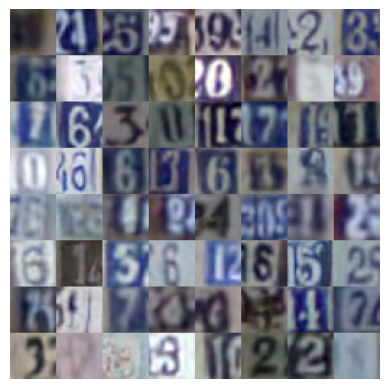

In [21]:
samples = sample(model, image_size=image_size, batch_size=64, channels=input_channels)
samples = (torch.Tensor(samples[-1]) + 1) * 0.5
show_image(samples)

In [22]:
# samples

In [22]:
with open(f"logs/log" + ".json", 'r') as f:
    logger = json.load(f)

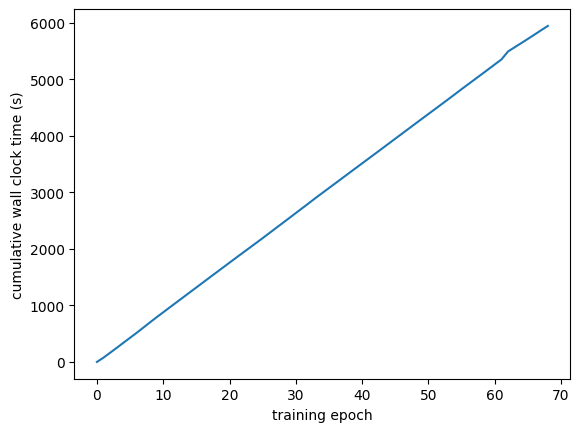

In [42]:
matplotlib.pyplot.figure("train_time")
matplotlib.pyplot.plot(numpy.concatenate([logger["train_time"][:62], numpy.array(logger["train_time"][63:70]) + logger["train_time"][61]]), c="C0")
# matplotlib.pyplot.plot(range(63, 70), numpy.array(logger["train_time"][63:70]) + logger["train_time"][61], c="C0")

matplotlib.pyplot.xlabel("training epoch")
matplotlib.pyplot.ylabel("cumulative wall clock time (s)")

matplotlib.pyplot.savefig("results/p2q2a.pdf")
matplotlib.pyplot.show()

In [44]:
with open(f"results/data_dict" + ".pickle", 'rb') as f:
    data_dict = pickle.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 640x480 with 0 Axes>

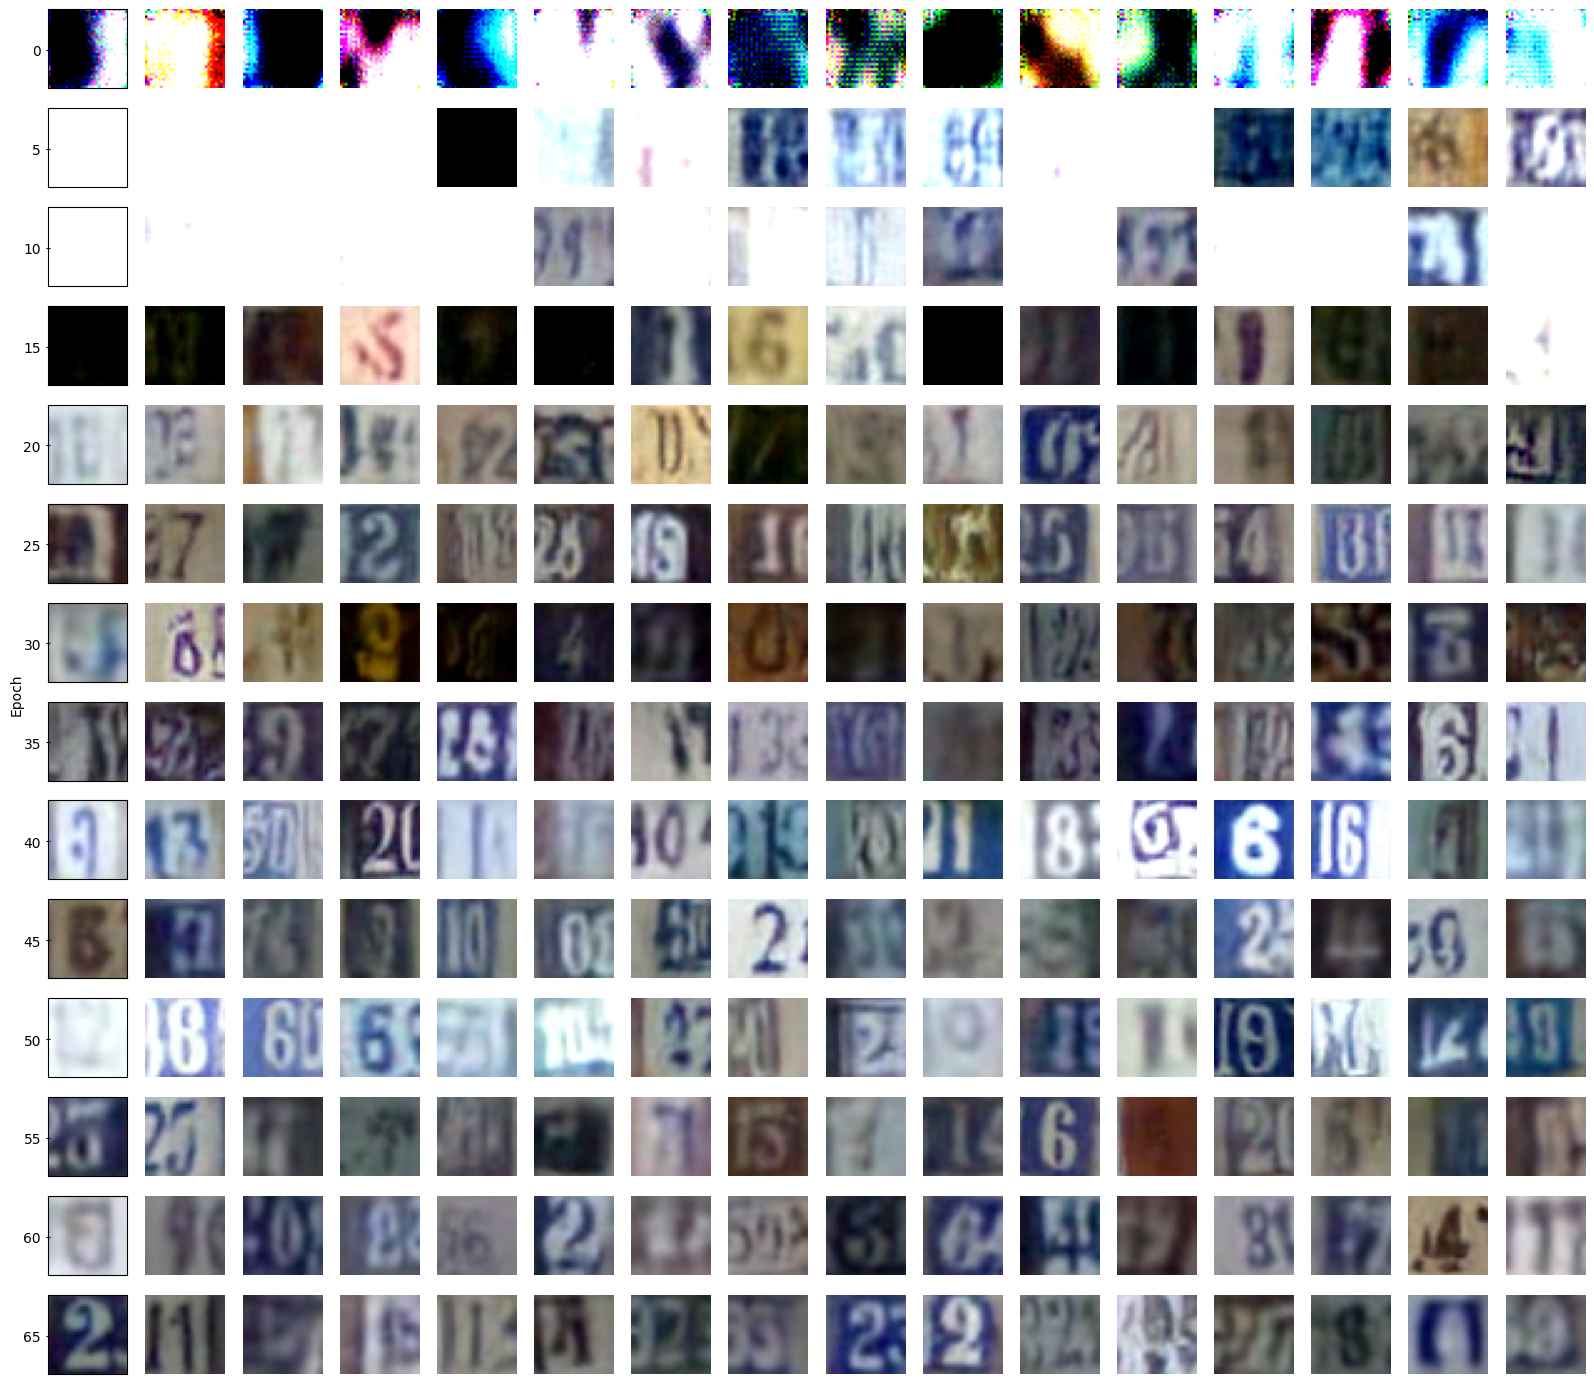

In [46]:
lst_fig_name = ["samples"]
for fig_name in lst_fig_name:

    jump, max_img = 5, 16
    image_list = data_dict[fig_name][::jump][:14]
    n = len(image_list)

    # Create a figure with 30 columns and 64 rows of subplots
    plt.figure(fig_name)
    fig, axs = plt.subplots(nrows=n, ncols=max_img, figsize=(max_img, n))
    fig.subplots_adjust(wspace=0.02)

    # Define a custom y-axis
    y_axis_labels = numpy.array(range(n)) * jump  # replace with your desired labels

    # Loop over the columns and rows of the subplot grid, and plot each small image
    for i in range(n):
        for j in range(max_img):
            axs[i, j].imshow((image_list[i][j].transpose(1, 2, 0) + 1) * 0.5)
            axs[i, j].axis('off')

        axs[i][0].axis('on')
        axs[i][0].set_xticks([])
        axs[i][0].set_yticks([16])
        axs[i][0].set_yticklabels([y_axis_labels[i]])
        axs[i][0].tick_params(axis='y', direction='inout', labelleft=True, labelright=False)

    fig.text(0.002, 0.5, 'Epoch', va='center', rotation='vertical')
    fig.tight_layout()

    fig.savefig("results/" + fig_name + "_ddpm.pdf")

plt.show()

In [47]:
imgs_batch = list(test_dataloader)[0][0]

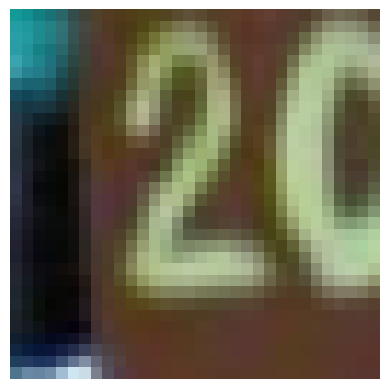

In [48]:
img_start = (imgs_batch[47][None]).to(device)
show_image((img_start + 1) * 0.5, nrow=16)

In [52]:
def p_sample_loop_img(model, img, shape, timesteps):
    with torch.no_grad():
        b = shape[0]
        img = img.to(device)
        imgs = []

        for i in tqdm(reversed(range(0, timesteps)), desc='Sampling', total=T, leave=False):
            img = p_sample(model, img, torch.full(size=(b,), fill_value=i, device=device), i)
            imgs.append(img.cpu())

        return torch.stack(imgs)


img_start = (imgs_batch[47][None]).to(device)
t_star, step = 272, 16
img_start = img_start.repeat(t_star // step, 1, 1, 1)
t = torch.arange(0, t_star, step, device=device)
imgs_noised = q_sample(img_start, t, noise=None)
b = imgs_noised.shape[0]

samples = p_sample_loop_img(model, imgs_noised, shape=(b, 3, 32, 32), timesteps=32)
t = t.cpu()

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
# (samples[-1] + 1) * 0.5 / torch.max(torch.abs(samples[-1]), dim=0, keepdim=True).values

In [53]:
jump_step, jump_img = 2, 1
samples = samples[::jump_step, ::jump_img, :, :, :]

In [166]:
samples.shape, n, t_i

(torch.Size([48, 1, 3, 32, 32]), 1, 48)

<Figure size 640x480 with 0 Axes>

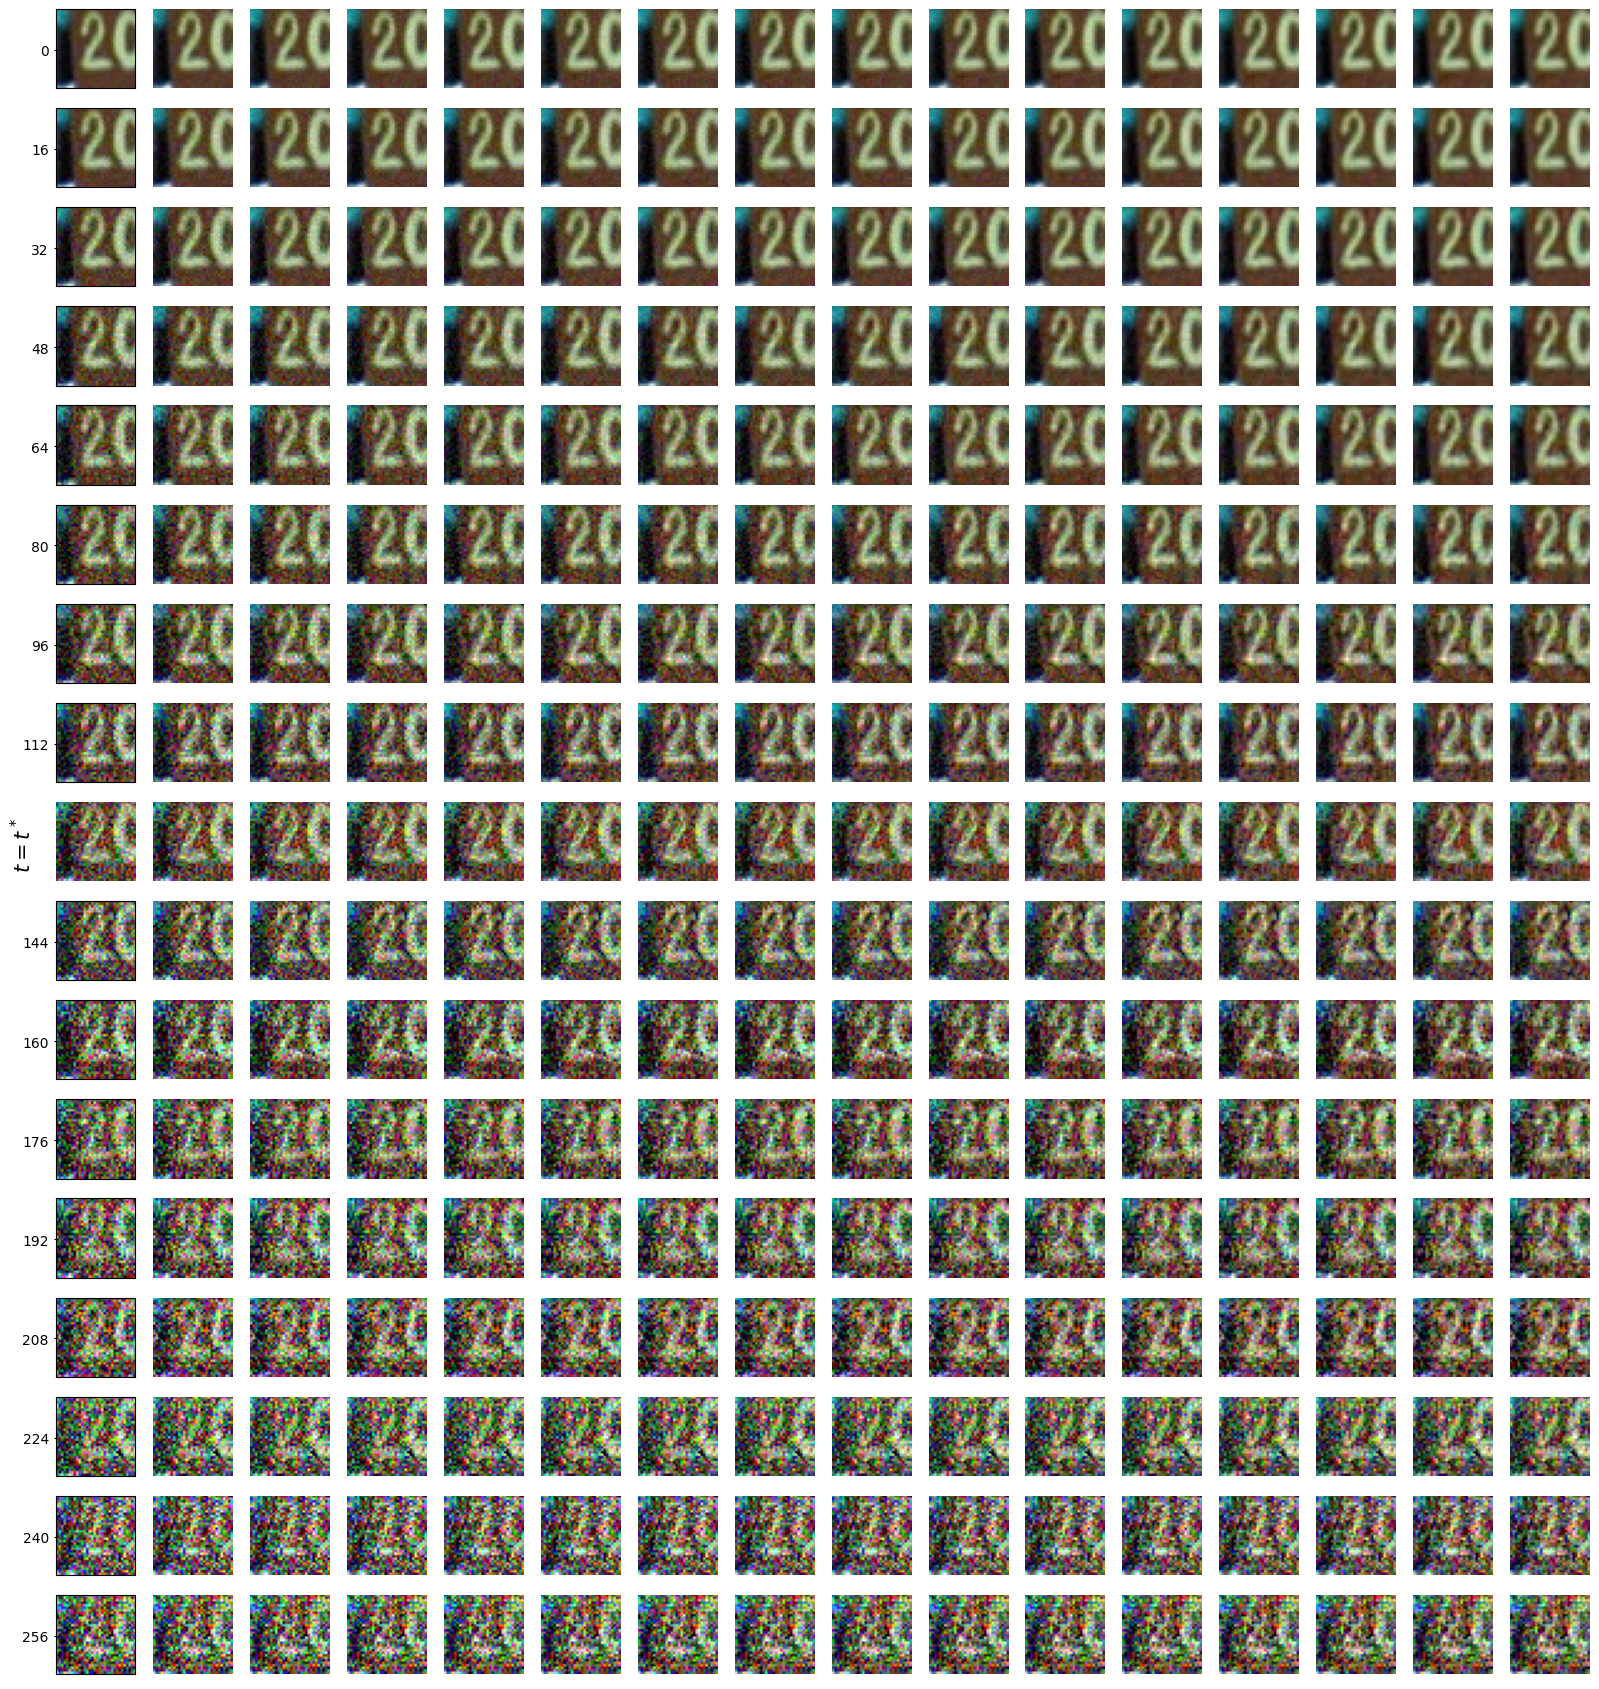

In [58]:
t_i = samples.shape[0]
n = samples.shape[1]

# Create a figure with 30 columns and 64 rows of subplots
plt.figure("denoising")
fig, axs = plt.subplots(nrows=n, ncols=t_i, figsize=(t_i, n), constrained_layout=True)
# fig.subplots_adjust(wspace=0, hspace=0)

# Define a custom y-axis
y_axis_labels = t.numpy(force=True)[::jump_img]  # numpy.array(range(n)) * jump  # replace with your desired labels

# Loop over the columns and rows of the subplot grid, and plot each small image
for k in range(n):
    for i in range(t_i):
        axs[k, i].imshow(numpy.clip((numpy.transpose(samples[i][k].numpy(force=True), axes=(1, 2, 0)) + 1) * 0.5, a_min=0, a_max=1))
        axs[k, i].axis('off')
    if k == 8: continue
    axs[k][0].axis('on')
    axs[k][0].set_xticks([])
    axs[k][0].set_yticks([16])
    axs[k][0].set_yticklabels([y_axis_labels[k]])
    axs[k][0].tick_params(axis='y', direction='inout', labelleft=True, labelright=False)

fig.text(0.0025, 0.5, r'$t=t^*$', va='center', rotation='vertical', size=15)
fig.tight_layout()

fig.savefig("results/p2q2c" + ".pdf")


In [ ]:
# with open(f"results/log/log" + ".json", 'r') as f:
#     logger = json.load(f)

In [ ]:
# matplotlib.pyplot.figure("train_time")
# matplotlib.pyplot.plot(logger["train_time"])
#
# matplotlib.pyplot.xlabel("training epoch")
# matplotlib.pyplot.ylabel("cumulative wall clock time (s)")
#
# matplotlib.pyplot.savefig("results/p1q3a1.pdf")
# matplotlib.pyplot.show()

In [ ]:
# matplotlib.pyplot.figure("train_losses")
# matplotlib.pyplot.plot(logger["train_losses"])
#
# matplotlib.pyplot.xlabel("training epoch")
# matplotlib.pyplot.ylabel("train loss (s)")
#
# matplotlib.pyplot.savefig("results/p1q3a2.pdf")
# matplotlib.pyplot.show()